In [6]:
import scanpy as sc


ctrl_adata = sc.read_h5ad('gt_merfish.h5ad')

target_domain = ctrl_adata.obs['Region'].unique()[0] 

temp =  sc.read_h5ad('perturbed_merfish.h5ad')

cond_adata = temp[temp.obs['slice_id'] == '0'].copy()

/home/cuiyan/miniconda3/envs/taichi-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [24]:
import anndata as ad 

ctrl_adata.obs['condition'] = 0

cond_adata.obs['condition'] = 1

run_adata = ad.concat([ctrl_adata, cond_adata], label='slice_id')

run_adata.obs['condition'] = run_adata.obs['condition'].astype('category')

In [25]:
import time
from Taichi.model import Taichi


import scanpy as sc 
import time
import numpy as np
import anndata as ad

start_time = time.time()

model = Taichi(run_adata, ct_obs='cell_type', slice_id='slice_id')

model.mender_init(scale=4, radius=15, nn_mode='radius')

model.run_mender(n_process=200)

model.label_refinement()

res = model.graph_diffusion()

res = res[res.obs['condition'] == 1]

end_time = time.time()

print(f'Total Running Time {end_time - start_time}')

default number of process is 200
total batch: 2, running batch 0
total batch: 2, running batch 1
scale 0, median #cells per radius (r=15): 2.0
scale 0, median #cells per radius (r=15): 2.0
scale 1, median #cells per radius (r=15): 4.0
scale 1, median #cells per radius (r=15): 4.0
scale 2, median #cells per radius (r=15): 6.0
scale 2, median #cells per radius (r=15): 6.0
scale 3, median #cells per radius (r=15): 9.0
scale 3, median #cells per radius (r=15): 
9.0Total Running Time 6.574989557266235


In [21]:
import numpy as np
from scipy.spatial import *
from sklearn.preprocessing import *
import scanpy as sc

def calculate_confusion_metrics_per_sample(y_true, y_pred):
    metrics_list = []  # List to hold all metrics
    
    # Loop through each sample
    for i in range(len(y_true)):
        tp = fn = fp = tn = 0  # Initialize counters for each category
        
        if y_true[i] == 1 and y_pred[i] == 1:
            metrics_list.append('TP')
        elif y_true[i] == 0 and y_pred[i] == 0:
            metrics_list.append('TN')
        elif y_true[i] == 0 and y_pred[i] == 1:
            metrics_list.append('FP')
        elif y_true[i] == 1 and y_pred[i] == 0:
            metrics_list.append('FN')
    
    return metrics_list



labels = (res.obs['Region'] == target_domain).values
taichi = res.obs['new_labels'].values
res.obs['Taichi_cons'] = calculate_confusion_metrics_per_sample(labels, taichi)
res.obsm['X_spatial'] = res.obsm['spatial']
res.obs['new_labels'] = res.obs['new_labels'].astype(str).astype('category')
sc.tl.embedding_density(res, basis='spatial', groupby='new_labels')
res.obs['spatial_density_new_labels'][res.obs['new_labels'] == '0.0'] = -1

In [10]:
import matplotlib.pyplot as plt

from palettable.cartocolors.sequential import agSunset_7

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20  # Adjust title size
plt.rcParams['axes.labelsize'] = 15

def plot_categorical_scatter(ax, x, y, groups, colors_markers, figsize=(5, 3), label=None):
    """
    Plots a scatter graph where color and marker type are determined by categorical groups.

    :param x: List or array of x coordinates
    :param y: List or array of y coordinates
    :param groups: List or array of group labels (categorical data)
    :param colors_markers: Dictionary mapping groups to (color, marker) tuples
    """
    
    unique_groups = set(groups)

    for group in unique_groups:
        # Select data for the current group
        ix = [i for i, g in enumerate(groups) if g == group]
        color, marker,s = colors_markers[group]
        sc = ax.scatter([x[i] for i in ix], [y[i] for i in ix], label=group, color=color, marker=marker, alpha=0.7, s=s)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis(False)
    #plt.legend().remove()
    return sc


def plot_continuous_scatter(ax, x, y, values, cmap, label=None):
    """
    Plots a scatter graph on a given axis where colors represent continuous values using a colormap.
    """
    norm = plt.Normalize(np.min(values), np.max(values))
    colors = plt.cm.get_cmap(cmap)(norm(values))
    
    sc = ax.scatter(x, y, color=colors, s=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis(False)
    #plt.legend().remove()
    return sc, norm  # Return the scatter plot and norm for use in colorbar

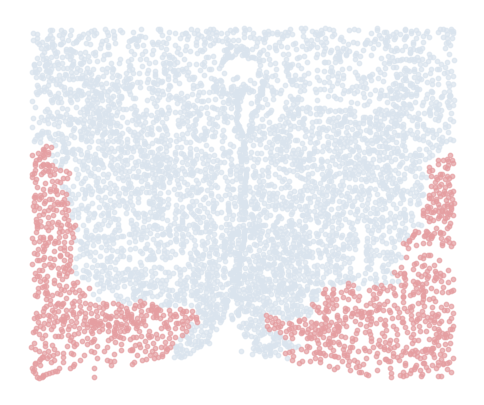

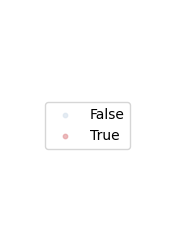

In [40]:
all_handles_labels = []

num_methods = 1
# Create a subplot grid
fig, ax = plt.subplots(1, num_methods, figsize=(6 * num_methods, 5))
x = res.obsm['spatial'][:,0]
y = res.obsm['spatial'][:,1]
groups = labels

# Define colors and markers for each group
colors_markers = {
    0: ('#DAE4EE', 'o', 10),  
    1: ('#E59EA1', 'o', 10), 
}
sc = plot_categorical_scatter(ax, x, y, groups, colors_markers=colors_markers)
g = [ax]

for i, ax in enumerate(g):
    #ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in [l for _, l in all_handles_labels]:
            all_handles_labels.append((handle, label))

plt.show()

unique_handles_labels =  dict(all_handles_labels).items()
fig_legend, ax_legend = plt.subplots(figsize=(2, 3))  # Adjust size as needed
fig_legend.legend(*zip(*unique_handles_labels), loc='center')
ax_legend.axis('off')
plt.show()

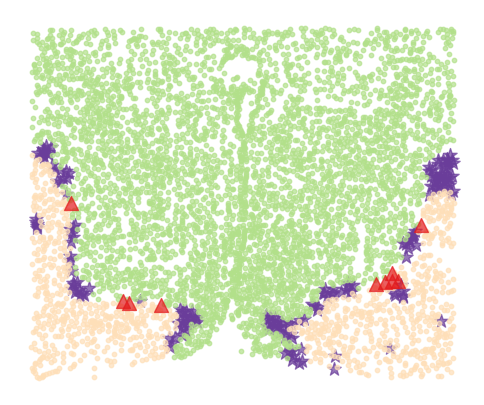

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

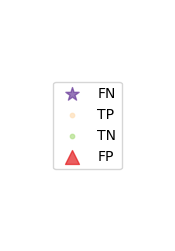

In [22]:
all_handles_labels = []

num_methods = 1
# Create a subplot grid
fig, ax = plt.subplots(1, num_methods, figsize=(6 * num_methods, 5))
x = res.obsm['spatial'][:,0]
y = res.obsm['spatial'][:,1]
groups = res.obs['Taichi_cons'].values

# Define colors and markers for each group
colors_markers = {
    'TP': ('#FEDFB8', 'o', 10),  
    'TN': ('#B2E08A', 'o', 10), 
    'FP': ('#E31A1C', '^', 100),
    'FN':('#6A3D9A', '*', 100) 
}
sc = plot_categorical_scatter(ax, x, y, groups, colors_markers=colors_markers)
g = [ax]

for i, ax in enumerate(g):
    #ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in [l for _, l in all_handles_labels]:
            all_handles_labels.append((handle, label))

plt.show()

unique_handles_labels =  dict(all_handles_labels).items()
fig_legend, ax_legend = plt.subplots(figsize=(2, 3))  # Adjust size as needed
fig_legend.legend(*zip(*unique_handles_labels), loc='center')
ax_legend.axis('off')
plt.show()

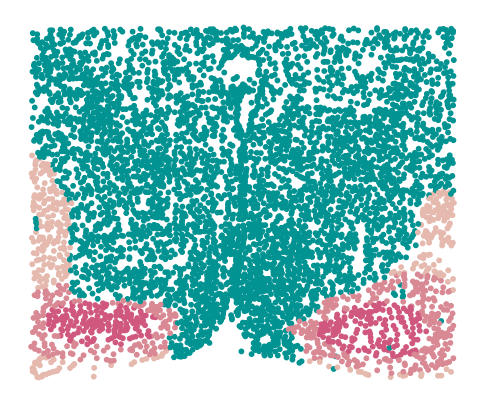

In [23]:

from palettable.cartocolors.diverging import TealRose_6
from matplotlib.colors import ListedColormap

all_handles_labels = []

num_methods = 1
# Create a subplot grid
fig, ax = plt.subplots(1, num_methods, figsize=(6 * num_methods, 5))
x = res.obsm['spatial'][:,0]
y = res.obsm['spatial'][:,1]
values = res.obs['spatial_density_new_labels'].values

cmap = ListedColormap(TealRose_6.mpl_colors)

sc, norm = plot_continuous_scatter(ax, x, y, values, cmap=cmap)

plt.show()